In [2]:
import os
import sys
sys.path.append('/home/fchinu/DmesonAnalysis/utils')
import argparse
import pickle
import yaml
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from hipe4ml import plot_utils
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
import pyarrow.parquet as pq

Failed to load image Python extension: /home/fchinu/.virtualenv/ml/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE


In [3]:
def read_parquet_in_batches(file_path, selections, batch_size=1000000):
    parquet_file = pq.ParquetFile(file_path)
    df = []
    for batch in parquet_file.iter_batches(batch_size):
        batch_df = batch.to_pandas()
        batch_df = batch_df.query(selections)
        df.append(batch_df)
    return pd.concat(df)

In [4]:
def train_test(TrainCols, TrainTestData): #pylint: disable=too-many-statements, too-many-branches
    '''
    function for model training and testing
    '''
    n_classes = len(np.unique(TrainTestData[3]))
    modelClf = xgb.XGBClassifier(use_label_encoder=False)
    HyperPars = {'max_depth':7, 'learning_rate':0.029, 'n_estimators':500, 'min_child_weight':2.7, 'subsample':0.90, 'colsample_bytree':0.97, 'n_jobs':1, 'tree_method':'hist', 'lambda':0.01}
    if not isinstance(TrainCols, list):
        print('\033[91mERROR: training columns must be defined!\033[0m')
        sys.exit()
    if not isinstance(HyperPars, dict):
        print('\033[91mERROR: hyper-parameters must be defined or be an empty dict!\033[0m')
        sys.exit()
    ModelHandl = ModelHandler(modelClf, TrainCols, HyperPars)

    # hyperparams optimization
    
    print('Perform opt tuna optimization')

    OptTunaConfig = {'max_depth': (1, 3), 
                        'learning_rate': (0.01, 0.1),
                        'n_estimators': (300, 1500), 
                        'min_child_weight': (1, 10),
                        'subsample': (0.8, 1.), 
                        'colsample_bytree': (0.8, 1.),
                        'lambda': (0., 0.001)}
    if not isinstance(OptTunaConfig, dict):
        print('\033[91mERROR: opt_tuna_config must be defined!\033[0m')
        sys.exit()

    if n_classes > 2:
        average_method = 'macro'
        roc_method = 'ovo'
        if not (average_method in ['macro', 'weighted'] and roc_method in ['ovo', 'ovr']):
            print('\033[91mERROR: selected ROC configuration is not valid!\033[0m')
            sys.exit()

        if average_method == 'weighted':
            metric = f'roc_auc_{roc_method}_{average_method}'
        else:
            metric = f'roc_auc_{roc_method}'
    else:
        metric = 'roc_auc'
    
    if isinstance(OptTunaConfig['max_depth'][0],float) or isinstance(OptTunaConfig['max_depth'][1],float):
        print('\033[93mWARNING: max_depth limits are not integers!\033[0m')
    if isinstance(OptTunaConfig['n_estimators'][0],float) or isinstance(OptTunaConfig['n_estimators'][1],float):
        print('\033[93mWARNING: n_estimators limits are not integers!\033[0m')
    if isinstance(OptTunaConfig['learning_rate'][0],int) or isinstance(OptTunaConfig['learning_rate'][1],int):
        print('\033[93mWARNING: learning_rate limits are not floats!\033[0m')
    if isinstance(OptTunaConfig['min_child_weight'][0],int) or isinstance(OptTunaConfig['min_child_weight'][1],int):
        print('\033[93mWARNING: min_child_weight limits are not integers!\033[0m')
    if isinstance(OptTunaConfig['subsample'][0],int) or isinstance(OptTunaConfig['subsample'][1],int):
        print('\033[93mWARNING: subsample limits are not integers!\033[0m')
    if isinstance(OptTunaConfig['colsample_bytree'][0],int) or isinstance(OptTunaConfig['colsample_bytree'][1],int):
        print('\033[93mWARNING: colsample_bytree limits are not integers!\033[0m')

    print('Performing hyper-parameters optimisation: ...', end='\r')

    ModelHandl.optimize_params_optuna(TrainTestData, OptTunaConfig, cross_val_scoring=metric,
                                n_jobs=5, 
                                n_trials=15,
                                direction='maximize')
    print('Performing hyper-parameters optimisation: Done!')
    print(f'Best hyper-parameters:\n{ModelHandl.get_model_params()}')

    # train and test the model with the updated hyper-parameters
    yPredTest = ModelHandl.train_test_model(TrainTestData, True, False,
                                            average='macro',
                                            multi_class_opt='ovo')
    yPredTrain = ModelHandl.predict(TrainTestData[0], False)

    return ModelHandl


In [126]:
BkgDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet", "2<fPt<2.5")

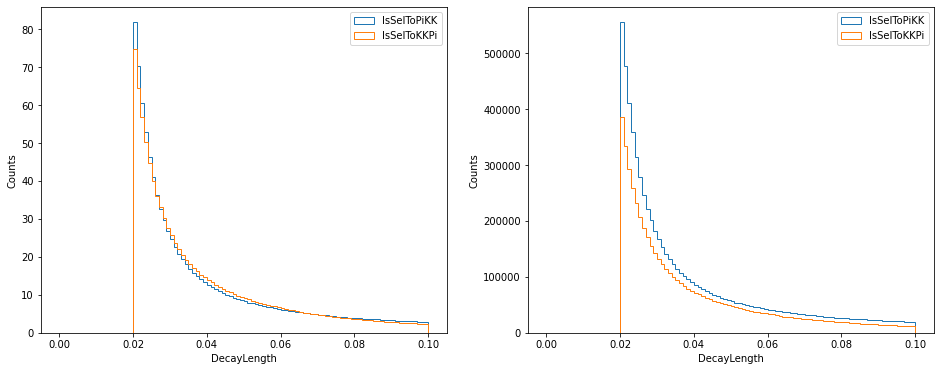

In [131]:
#Draw the DecayLength distribution for the IsSelToKKPi and IsSelToPiKK
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(BkgDf.query('fIsSelDsToPiKK>=3')["fDecayLength"], bins=100, range=(0, 0.1), histtype='step', label='IsSelToPiKK', density = True)
ax[0].hist(BkgDf.query('fIsSelDsToKKPi>=3')["fDecayLength"], bins=100, range=(0, 0.1), histtype='step', label='IsSelToKKPi', density = True)
ax[0].set_xlabel('DecayLength')
ax[0].set_ylabel('Counts')
ax[0].legend()
ax[1].hist(BkgDf.query('fIsSelDsToPiKK>=3')["fDecayLength"], bins=100, range=(0, 0.1), histtype='step', label='IsSelToPiKK')
ax[1].hist(BkgDf.query('fIsSelDsToKKPi>=3')["fDecayLength"], bins=100, range=(0, 0.1), histtype='step', label='IsSelToKKPi')
ax[1].set_xlabel('DecayLength')
ax[1].set_ylabel('Counts')
ax[1].legend()
plt.show()

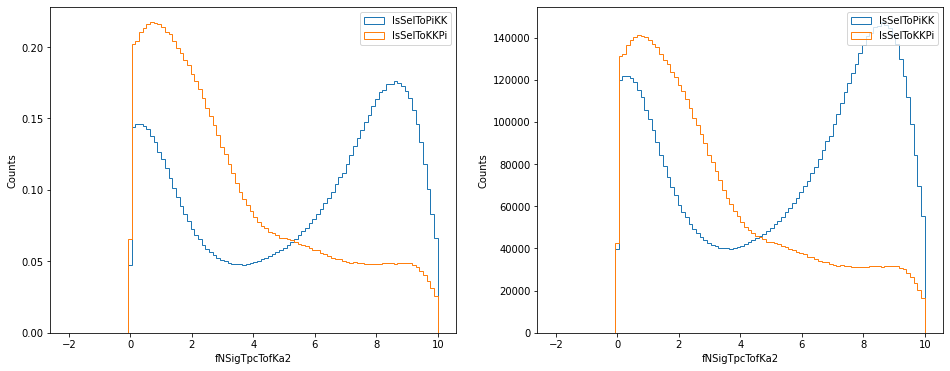

In [132]:
#Draw the fNSigTpcTofKa2 distribution for the IsSelToKKPi and IsSelToPiKK
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(BkgDf.query('fIsSelDsToPiKK>=3')["fNSigTpcTofKa2"], bins=100, range=(-2, 10), histtype='step', label='IsSelToPiKK', density = True)
ax[0].hist(BkgDf.query('fIsSelDsToKKPi>=3')["fNSigTpcTofKa2"], bins=100, range=(-2, 10), histtype='step', label='IsSelToKKPi', density = True)
ax[0].set_xlabel('fNSigTpcTofKa2')
ax[0].set_ylabel('Counts')
ax[0].legend()
ax[1].hist(BkgDf.query('fIsSelDsToPiKK>=3')["fNSigTpcTofKa2"], bins=100, range=(-2, 10), histtype='step', label='IsSelToPiKK')
ax[1].hist(BkgDf.query('fIsSelDsToKKPi>=3')["fNSigTpcTofKa2"], bins=100, range=(-2, 10), histtype='step', label='IsSelToKKPi')
ax[1].set_xlabel('fNSigTpcTofKa2')
ax[1].set_ylabel('Counts')
ax[1].legend()
plt.show()

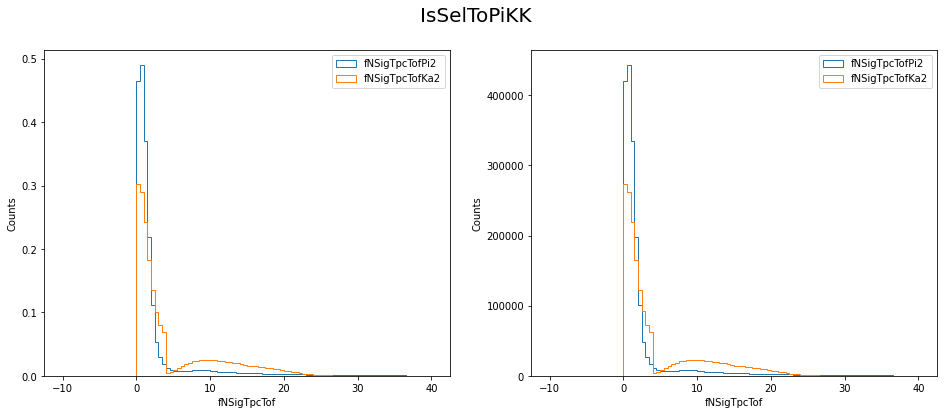

In [140]:
#Draw the fNSigTpcTof distribution for the IsSelToKKPi and IsSelToPiKK
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(BkgDf.query('fIsSelDsToPiKK>=5')["fNSigTpcTofPi2"], bins=100, range=(-10, 40), histtype='step', label='fNSigTpcTofPi2', density = True)
ax[0].hist(BkgDf.query('fIsSelDsToPiKK>=5')["fNSigTpcTofKa2"], bins=100, range=(-10, 40), histtype='step', label='fNSigTpcTofKa2', density = True)
ax[0].set_xlabel('fNSigTpcTof')
ax[0].set_ylabel('Counts')
ax[0].legend()
ax[1].hist(BkgDf.query('fIsSelDsToPiKK>=5')["fNSigTpcTofPi2"], bins=100, range=(-10, 40), histtype='step', label='fNSigTpcTofPi2')
ax[1].hist(BkgDf.query('fIsSelDsToPiKK>=5')["fNSigTpcTofKa2"], bins=100, range=(-10, 40), histtype='step', label='fNSigTpcTofKa2')
ax[1].set_xlabel('fNSigTpcTof')
ax[1].set_ylabel('Counts')
ax[1].legend()
fig.suptitle('IsSelToPiKK', fontsize=20)
plt.show()

## Training

In [120]:
BkgDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet", "2<fPt<2.5 and (2.05<fM<2.1 or 1.7<fM<1.75)")
PromptDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train165702/Merged_LHC22b1b_Train165702_DsPrompt_Train.parquet", "2<fPt<2.5")
FDDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train165701/Merged_LHC22b1a_Train165701_DsFD_Train.parquet", "2<fPt<2.5")

In [6]:
PromptDf.columns

Index(['fPtProng0', 'fPtProng1', 'fPtProng2', 'fImpactParameter0',
       'fImpactParameter1', 'fImpactParameter2', 'fNSigTpcPi0', 'fNSigTpcKa0',
       'fNSigTofPi0', 'fNSigTofKa0', 'fNSigTpcTofPi0', 'fNSigTpcTofKa0',
       'fNSigTpcPi1', 'fNSigTpcKa1', 'fNSigTofPi1', 'fNSigTofKa1',
       'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcPi2', 'fNSigTpcKa2',
       'fNSigTofPi2', 'fNSigTofKa2', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2',
       'fIsSelDsToKKPi', 'fIsSelDsToPiKK', 'fM', 'fPt', 'fEta', 'fPhi', 'fY',
       'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised',
       'fDecayLengthXYNormalised', 'fCpa', 'fCpaXY', 'fMaxNormalisedDeltaIP',
       'fImpactParameterXY', 'fDeltaMassPhi', 'fAbsCos3PiK', 'fChi2PCA',
       'fFlagMcMatchRec', 'fOriginMcRec', 'fFlagMcDecayChanRec'],
      dtype='object')

In [7]:
nPrompt = len(PromptDf)
nFD = len(FDDf)
nBkg = len(BkgDf)
nCandToKeep = min([nPrompt, nFD, nBkg])
TotDf = pd.concat([BkgDf.iloc[:nCandToKeep], PromptDf.iloc[:nCandToKeep], FDDf.iloc[:nCandToKeep]], sort=True)
LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep + [2]*nCandToKeep)

TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=0.2,
                                                                random_state=42)

TrainTestData = [TrainSet, yTrain, TestSet, yTest]
PromptDfSelForEff = pd.concat([PromptDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 1]], sort=False)
FDDfSelForEff = pd.concat([FDDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 2]], sort=False)
del TotDf

#### Change training variables

In [7]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/All.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/All.model', True)

[I 2024-03-05 10:35:44,731] A new study created in memory with name: no-name-bc5c2d3e-25cf-4014-84ff-2319b7792d5b


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 10:35:59,591] Trial 3 finished with value: 0.9585361398088054 and parameters: {'max_depth': 3, 'learning_rate': 0.023613017810110142, 'n_estimators': 303, 'min_child_weight': 3, 'subsample': 0.9428245365922474, 'colsample_bytree': 0.8775225449892474, 'lambda': 0.00046745882357419546}. Best is trial 3 with value: 0.9585361398088054.
[I 2024-03-05 10:36:01,482] Trial 4 finished with value: 0.9604751576148981 and parameters: {'max_depth': 3, 'learning_rate': 0.054618733444134246, 'n_estimators': 361, 'min_child_weight': 3, 'subsample': 0.9359408544543462, 'colsample_bytree': 0.894883709038583, 'lambda': 0.00014014631261604905}. Best is trial 4 with value: 0.9604751576148981.
[I 2024-03-05 10:36:16,698] Trial 1 finished with value: 0.960713742284336 and parameters: {'max_depth': 3, 'learning_rate': 0.05959152090139804, 'n_estimator

Number of finished trials: 15
Best trial:
Value: 0.9608243789041
Params: 
    max_depth: 3
    learning_rate: 0.04003780633946117
    n_estimators: 805
    min_child_weight: 4
    subsample: 0.8264622621315358
    colsample_bytree: 0.8853410836329956
    lambda: 0.00013468906315562514
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8853410836329956, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.04003780633946117, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 805, 'n_jobs': 

In [8]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoChi2PCA.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoChi2PCA.model', True)

[I 2024-03-05 10:37:40,593] A new study created in memory with name: no-name-88c8194d-9d90-4271-8ba0-fe6d8aa63cd0


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 10:37:58,277] Trial 2 finished with value: 0.9434335018412096 and parameters: {'max_depth': 2, 'learning_rate': 0.015227364408800556, 'n_estimators': 451, 'min_child_weight': 5, 'subsample': 0.9452577812076773, 'colsample_bytree': 0.9398445280507453, 'lambda': 6.382399838131192e-05}. Best is trial 2 with value: 0.9434335018412096.
[I 2024-03-05 10:38:11,339] Trial 0 finished with value: 0.9519930615675254 and parameters: {'max_depth': 3, 'learning_rate': 0.024066052025014082, 'n_estimators': 694, 'min_child_weight': 2, 'subsample': 0.8767905720283115, 'colsample_bytree': 0.820895225052663, 'lambda': 0.0008929399411483799}. Best is trial 0 with value: 0.9519930615675254.
[I 2024-03-05 10:38:16,097] Trial 4 finished with value: 0.9524732445472068 and parameters: {'max_depth': 2, 'learning_rate': 0.04928548272017873, 'n_estimators

Number of finished trials: 15
Best trial:
Value: 0.9538244946488647
Params: 
    max_depth: 3
    learning_rate: 0.06386524004733427
    n_estimators: 664
    min_child_weight: 6
    subsample: 0.8434610205775086
    colsample_bytree: 0.8890183259633025
    lambda: 0.0003767177297675996
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8890183259633025, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.06386524004733427, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 6, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 664, 'n_jobs'

In [9]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoAbsCos3PiK.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoAbsCos3PiK.model', True)

[I 2024-03-05 10:39:53,871] A new study created in memory with name: no-name-9e98c21b-8744-4a8d-a5ff-7c857f08e825


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 10:40:11,264] Trial 0 finished with value: 0.9527406741767305 and parameters: {'max_depth': 2, 'learning_rate': 0.013608397343356005, 'n_estimators': 441, 'min_child_weight': 8, 'subsample': 0.8254942474440722, 'colsample_bytree': 0.8246650872175293, 'lambda': 0.00048651794552717186}. Best is trial 0 with value: 0.9527406741767305.
[I 2024-03-05 10:40:20,385] Trial 4 finished with value: 0.9592282861332994 and parameters: {'max_depth': 3, 'learning_rate': 0.08142153381494124, 'n_estimators': 625, 'min_child_weight': 6, 'subsample': 0.991078830116769, 'colsample_bytree': 0.8608163294891894, 'lambda': 0.0004895997160742936}. Best is trial 4 with value: 0.9592282861332994.
[I 2024-03-05 10:40:26,652] Trial 1 finished with value: 0.9560691118268625 and parameters: {'max_depth': 1, 'learning_rate': 0.08466317718781514, 'n_estimators

Number of finished trials: 15
Best trial:
Value: 0.9594109136413156
Params: 
    max_depth: 3
    learning_rate: 0.03397280751481495
    n_estimators: 1215
    min_child_weight: 1
    subsample: 0.8752283786282866
    colsample_bytree: 0.8786975938252509
    lambda: 8.652347175831343e-05
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8786975938252509, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03397280751481495, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1215, 'n_job

In [10]:
TrainCols = ['fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoCPAs.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoCPAs.model', True)

[I 2024-03-05 10:42:17,872] A new study created in memory with name: no-name-cf9ba6d5-9e42-4928-93d2-0148154ecade


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 10:42:45,904] Trial 0 finished with value: 0.9377299323897116 and parameters: {'max_depth': 1, 'learning_rate': 0.03546151911823777, 'n_estimators': 923, 'min_child_weight': 3, 'subsample': 0.8952053061050436, 'colsample_bytree': 0.8965268176343888, 'lambda': 0.00016953802428453567}. Best is trial 0 with value: 0.9377299323897116.
[I 2024-03-05 10:42:45,963] Trial 4 finished with value: 0.9395897487044683 and parameters: {'max_depth': 2, 'learning_rate': 0.016083602265400645, 'n_estimators': 760, 'min_child_weight': 9, 'subsample': 0.8129904866247465, 'colsample_bytree': 0.9505240923212075, 'lambda': 0.0006083392409372408}. Best is trial 4 with value: 0.9395897487044683.
[I 2024-03-05 10:42:57,412] Trial 3 finished with value: 0.942710474684185 and parameters: {'max_depth': 3, 'learning_rate': 0.026653996945746022, 'n_estimator

Number of finished trials: 15
Best trial:
Value: 0.9428394099476508
Params: 
    max_depth: 3
    learning_rate: 0.04662415502575702
    n_estimators: 1292
    min_child_weight: 9
    subsample: 0.8966753714744304
    colsample_bytree: 0.8507969892469808
    lambda: 0.0009250047659594322
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8507969892469808, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.04662415502575702, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 9, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1292, 'n_job

#### Change preselections

##### Cuts on decay length

In [8]:
SelBkgDf = BkgDf.query("fDecayLength > 0.05")
SelPromptDf = PromptDf.query("fDecayLength > 0.05")
SelFDDf = FDDf.query("fDecayLength > 0.05")
nPrompt = len(SelPromptDf)
nFD = len(SelFDDf)
nBkg = len(SelBkgDf)
nCandToKeep = min([nPrompt, nFD, nBkg])
TotDf = pd.concat([SelBkgDf.iloc[:nCandToKeep], SelPromptDf.iloc[:nCandToKeep], SelFDDf.iloc[:nCandToKeep]], sort=True)
LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep + [2]*nCandToKeep)

TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=0.2,
                                                                random_state=42)

TrainTestData = [TrainSet, yTrain, TestSet, yTest]
PromptDfSelForEff = pd.concat([PromptDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 1]], sort=False)
FDDfSelForEff = pd.concat([FDDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 2]], sort=False)
del TotDf

In [10]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/fDecayLength_0_05.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/fDecayLength_0_05.model', True)

[I 2024-03-05 12:11:00,182] A new study created in memory with name: no-name-89fcadf4-5475-43f3-bd9b-64c3200e3014


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 12:11:04,242] Trial 2 finished with value: 0.9791834564465207 and parameters: {'max_depth': 1, 'learning_rate': 0.045507463971629185, 'n_estimators': 497, 'min_child_weight': 5, 'subsample': 0.9761504435004296, 'colsample_bytree': 0.8095192155058902, 'lambda': 0.0005602287132914552}. Best is trial 2 with value: 0.9791834564465207.
[I 2024-03-05 12:11:10,037] Trial 1 finished with value: 0.9810896529658031 and parameters: {'max_depth': 2, 'learning_rate': 0.0654493286641717, 'n_estimators': 902, 'min_child_weight': 1, 'subsample': 0.8376103318884814, 'colsample_bytree': 0.8191028923664534, 'lambda': 0.0006948832756445065}. Best is trial 1 with value: 0.9810896529658031.
[I 2024-03-05 12:11:11,223] Trial 4 finished with value: 0.9802721982050521 and parameters: {'max_depth': 1, 'learning_rate': 0.09547173707468601, 'n_estimators'

Number of finished trials: 15
Best trial:
Value: 0.9812282094691678
Params: 
    max_depth: 2
    learning_rate: 0.05909200370204152
    n_estimators: 406
    min_child_weight: 6
    subsample: 0.9698156446610475
    colsample_bytree: 0.9380978066046337
    lambda: 0.0009453484215516466
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9380978066046337, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05909200370204152, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 2, 'max_leaves': None, 'min_child_weight': 6, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 406, 'n_jobs'

##### Cuts on chi2PCA

In [78]:
SelBkgDf = BkgDf.query("fChi2PCA < 5")
SelPromptDf = PromptDf.query("fChi2PCA < 5")
SelFDDf = FDDf.query("fChi2PCA < 5")
nPrompt = len(SelPromptDf)
nFD = len(SelFDDf)
nBkg = len(SelBkgDf)
nCandToKeep = min([nPrompt, nFD, nBkg])
TotDf = pd.concat([SelBkgDf.iloc[:nCandToKeep], SelPromptDf.iloc[:nCandToKeep], SelFDDf.iloc[:nCandToKeep]], sort=True)
LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep + [2]*nCandToKeep)

TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=0.2,
                                                                random_state=42)

TrainTestData = [TrainSet, yTrain, TestSet, yTest]
PromptDfSelForEff = pd.concat([PromptDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 1]], sort=False)
FDDfSelForEff = pd.concat([FDDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 2]], sort=False)
del TotDf

In [21]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/fChi2PCA_5.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/fChi2PCA_5.model', True)

[I 2024-03-05 12:30:31,959] A new study created in memory with name: no-name-44be70e4-ff51-4da2-8cfb-87c469d47c80


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 12:30:51,251] Trial 3 finished with value: 0.9567740385983046 and parameters: {'max_depth': 3, 'learning_rate': 0.03178993029676482, 'n_estimators': 404, 'min_child_weight': 1, 'subsample': 0.8197843295011663, 'colsample_bytree': 0.8220127101788491, 'lambda': 0.0003516722934997141}. Best is trial 3 with value: 0.9567740385983046.
[I 2024-03-05 12:30:51,425] Trial 2 finished with value: 0.9537472494695143 and parameters: {'max_depth': 2, 'learning_rate': 0.019261715318314485, 'n_estimators': 510, 'min_child_weight': 2, 'subsample': 0.9874279034756663, 'colsample_bytree': 0.8612433379294663, 'lambda': 0.00011642654759213334}. Best is trial 3 with value: 0.9567740385983046.
[I 2024-03-05 12:31:01,382] Trial 4 finished with value: 0.9580748336175848 and parameters: {'max_depth': 3, 'learning_rate': 0.04524414727712869, 'n_estimator

Number of finished trials: 15
Best trial:
Value: 0.9582338011160761
Params: 
    max_depth: 3
    learning_rate: 0.04119677082841865
    n_estimators: 740
    min_child_weight: 7
    subsample: 0.8503924243891227
    colsample_bytree: 0.8349216930689051
    lambda: 0.00011794257214948612
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8349216930689051, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.04119677082841865, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 740, 'n_jobs

##### Cuts on PID

In [121]:
SelBkgDf = BkgDf.query("(fIsSelDsToKKPi >=3 and fNSigTpcTofKa0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofPi2 < 4) or (fIsSelDsToPiKK >= 3 and fNSigTpcTofPi0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofKa2 < 4)")
SelPromptDf = PromptDf.query("(fIsSelDsToKKPi >=3 and fNSigTpcTofKa0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofPi2 < 4) or (fIsSelDsToPiKK >= 3 and fNSigTpcTofPi0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofKa2 < 4)")
SelFDDf = FDDf.query("(fIsSelDsToKKPi >=3 and fNSigTpcTofKa0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofPi2 < 4) or (fIsSelDsToPiKK >= 3 and fNSigTpcTofPi0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofKa2 < 4)")
nPrompt = len(SelPromptDf)
nFD = len(SelFDDf)
nBkg = len(SelBkgDf)
nCandToKeep = min([nPrompt, nFD, nBkg])
TotDf = pd.concat([SelBkgDf.iloc[:nCandToKeep], SelPromptDf.iloc[:nCandToKeep], SelFDDf.iloc[:nCandToKeep]], sort=True)
LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep + [2]*nCandToKeep)

TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=0.2,
                                                                random_state=42)

TrainTestData = [TrainSet, yTrain, TestSet, yTest]
PromptDfSelForEff = pd.concat([PromptDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 1]], sort=False)
FDDfSelForEff = pd.concat([FDDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 2]], sort=False)
del TotDf

In [122]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/PID_4.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/PID_4.model', True)

[I 2024-03-05 16:14:47,315] A new study created in memory with name: no-name-39324c89-c2e4-41f8-b130-f2a7281e0ec1


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 16:15:04,086] Trial 4 finished with value: 0.938467636280391 and parameters: {'max_depth': 2, 'learning_rate': 0.035941757687768444, 'n_estimators': 524, 'min_child_weight': 9, 'subsample': 0.9976549155016056, 'colsample_bytree': 0.9313498811285109, 'lambda': 0.0007201575070427312}. Best is trial 4 with value: 0.938467636280391.
[I 2024-03-05 16:15:05,174] Trial 3 finished with value: 0.9408343989587529 and parameters: {'max_depth': 3, 'learning_rate': 0.05827255349305942, 'n_estimators': 466, 'min_child_weight': 9, 'subsample': 0.8035825811794924, 'colsample_bytree': 0.8826018067091183, 'lambda': 0.000580949945131155}. Best is trial 3 with value: 0.9408343989587529.
[I 2024-03-05 16:15:16,130] Trial 1 finished with value: 0.9364059156731861 and parameters: {'max_depth': 1, 'learning_rate': 0.08389452035726483, 'n_estimators': 

Number of finished trials: 15
Best trial:
Value: 0.9412247950809214
Params: 
    max_depth: 3
    learning_rate: 0.02497475659358859
    n_estimators: 1278
    min_child_weight: 8
    subsample: 0.830197300762661
    colsample_bytree: 0.8532827132531535
    lambda: 0.0009021998873688953
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8532827132531535, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02497475659358859, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 8, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1278, 'n_jobs

### Train using only one sideband

In [5]:
BkgDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet", "2<fPt<2.5 and 2.05<fM<2.1")
PromptDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train165702/Merged_LHC22b1b_Train165702_DsPrompt_Train.parquet", "2<fPt<2.5")
FDDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train165701/Merged_LHC22b1a_Train165701_DsFD_Train.parquet", "2<fPt<2.5")

In [6]:
nPrompt = len(PromptDf)
nFD = len(FDDf)
nBkg = len(BkgDf)
nCandToKeep = min([nPrompt, nFD, nBkg])
TotDf = pd.concat([BkgDf.iloc[:nCandToKeep], PromptDf.iloc[:nCandToKeep], FDDf.iloc[:nCandToKeep]], sort=True)
LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep + [2]*nCandToKeep)

TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=0.2,
                                                                random_state=42)

TrainTestData = [TrainSet, yTrain, TestSet, yTest]
PromptDfSelForEff = pd.concat([PromptDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 1]], sort=False)
FDDfSelForEff = pd.concat([FDDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 2]], sort=False)
del TotDf

In [ ]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/Right_Sideband.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/Right_Sideband.model', True)

[I 2024-03-05 10:35:44,731] A new study created in memory with name: no-name-bc5c2d3e-25cf-4014-84ff-2319b7792d5b


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-05 10:35:59,591] Trial 3 finished with value: 0.9585361398088054 and parameters: {'max_depth': 3, 'learning_rate': 0.023613017810110142, 'n_estimators': 303, 'min_child_weight': 3, 'subsample': 0.9428245365922474, 'colsample_bytree': 0.8775225449892474, 'lambda': 0.00046745882357419546}. Best is trial 3 with value: 0.9585361398088054.
[I 2024-03-05 10:36:01,482] Trial 4 finished with value: 0.9604751576148981 and parameters: {'max_depth': 3, 'learning_rate': 0.054618733444134246, 'n_estimators': 361, 'min_child_weight': 3, 'subsample': 0.9359408544543462, 'colsample_bytree': 0.894883709038583, 'lambda': 0.00014014631261604905}. Best is trial 4 with value: 0.9604751576148981.
[I 2024-03-05 10:36:16,698] Trial 1 finished with value: 0.960713742284336 and parameters: {'max_depth': 3, 'learning_rate': 0.05959152090139804, 'n_estimator

Number of finished trials: 15
Best trial:
Value: 0.9608243789041
Params: 
    max_depth: 3
    learning_rate: 0.04003780633946117
    n_estimators: 805
    min_child_weight: 4
    subsample: 0.8264622621315358
    colsample_bytree: 0.8853410836329956
    lambda: 0.00013468906315562514
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8853410836329956, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.04003780633946117, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 805, 'n_jobs': 

In [14]:
BkgDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet", "2<fPt<2.5 and 1.7<fM<1.75")
PromptDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train165702/Merged_LHC22b1b_Train165702_DsPrompt_Train.parquet", "2<fPt<2.5")
FDDf = read_parquet_in_batches("/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train165701/Merged_LHC22b1a_Train165701_DsFD_Train.parquet", "2<fPt<2.5")

In [15]:
nPrompt = len(PromptDf)
nFD = len(FDDf)
nBkg = len(BkgDf)
nCandToKeep = min([nPrompt, nFD, nBkg])
TotDf = pd.concat([BkgDf.iloc[:nCandToKeep], PromptDf.iloc[:nCandToKeep], FDDf.iloc[:nCandToKeep]], sort=True)
LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep + [2]*nCandToKeep)

TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=0.2,
                                                                random_state=42)

TrainTestData = [TrainSet, yTrain, TestSet, yTest]
PromptDfSelForEff = pd.concat([PromptDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 1]], sort=False)
FDDfSelForEff = pd.concat([FDDf.iloc[nCandToKeep:], TestSet[np.array(yTest) == 2]], sort=False)
del TotDf

In [16]:
TrainCols = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fImpactParameterXY', 'fAbsCos3PiK', 'fChi2PCA',
                       'fNSigTpcTofPi0', 'fNSigTpcTofKa0', 'fNSigTpcTofPi1', 'fNSigTpcTofKa1', 'fNSigTpcTofPi2', 'fNSigTpcTofKa2'] 
ModelHandl = train_test(TrainCols, TrainTestData)
ModelHandl.dump_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/Left_Sideband.pickle')
ModelHandl.dump_original_model('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/Left_Sideband.model', True)

[I 2024-03-07 12:33:27,307] A new study created in memory with name: no-name-7620205c-61ea-4831-a741-94a5a7ead6c3


Perform opt tuna optimization


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2024-03-07 12:33:44,980] Trial 2 finished with value: 0.9594354562916703 and parameters: {'max_depth': 3, 'learning_rate': 0.02401018455376464, 'n_estimators': 352, 'min_child_weight': 2, 'subsample': 0.9184964006438684, 'colsample_bytree': 0.8267145070682688, 'lambda': 0.0007379143164043997}. Best is trial 2 with value: 0.9594354562916703.
[I 2024-03-07 12:34:02,027] Trial 4 finished with value: 0.9552564619636599 and parameters: {'max_depth': 1, 'learning_rate': 0.02043704842377931, 'n_estimators': 1038, 'min_child_weight': 7, 'subsample': 0.8259907315238066, 'colsample_bytree': 0.8970059853363924, 'lambda': 0.0009571019931813805}. Best is trial 2 with value: 0.9594354562916703.
[I 2024-03-07 12:34:02,584] Trial 0 finished with value: 0.9598474814357557 and parameters: {'max_depth': 2, 'learning_rate': 0.024054294252117497, 'n_estimator

Number of finished trials: 15
Best trial:
Value: 0.9608604676692056
Params: 
    max_depth: 2
    learning_rate: 0.07863833885148447
    n_estimators: 1027
    min_child_weight: 2
    subsample: 0.876996303596789
    colsample_bytree: 0.9734518789302719
    lambda: 0.000461132351248302
Performing hyper-parameters optimisation: Done!
Best hyper-parameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9734518789302719, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.07863833885148447, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 2, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1027, 'n_jobs'

In [11]:
del PromptDf, FDDf, BkgDf

## Application

In [10]:
def apply_model_in_batches(ModelHandl, ColsToKeep, file_path, selections, batch_size=1000000):
    parquet_file = pq.ParquetFile(file_path)
    df = []
    for batch in parquet_file.iter_batches(batch_size):
        batch_df = batch.to_pandas()
        batch_df = batch_df.query(selections)
        pred = ModelHandl.predict(batch_df, False)
        batch_df = batch_df.loc[:, ColsToKeep]
        batch_df['ML_output_bkg'] = pred[:, 0]
        batch_df['ML_output_prompt'] = pred[:, 1]
        batch_df['ML_output_FD'] = pred[:, 2]
        df.append(batch_df)
    return pd.concat(df)

In [11]:
def show_inv_mass_plots(DataDf):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    dfSel = DataDf.query(f"ML_output_bkg < 0.01 and ML_output_prompt > 0.5 and fIsSelDsToPiKK>=3")
    #plt.figure(figsize=(6, 6))
    counts,bin_edges = np.histogram(dfSel['fM'],bins=75, range=(1.7, 2.1))
    plt.errorbar(x=bin_edges[1:], y=counts, yerr=np.sqrt(counts), fmt='o', label='fIsSelDsToPiKK>=3')

    dfSel = DataDf.query(f"ML_output_bkg < 0.01 and ML_output_prompt > 0.5 and fIsSelDsToKKPi>=3")
    #plt.figure(figsize=(6, 6))
    counts,bin_edges = np.histogram(dfSel['fM'],bins=75, range=(1.7, 2.1))
    plt.errorbar(x=bin_edges[1:], y=counts, yerr=np.sqrt(counts), fmt='o', label='fIsSelDsToKKPi>=3')

    dfSel = DataDf.query(f"ML_output_bkg < 0.01 and ML_output_prompt > 0.5 and fIsSelDsToKKPi>=3 and fIsSelDsToPiKK>=3")
    #plt.figure(figsize=(6, 6))
    counts,bin_edges = np.histogram(dfSel['fM'],bins=75, range=(1.7, 2.1))
    plt.errorbar(x=bin_edges[1:], y=counts, yerr=np.sqrt(counts), fmt='o', label='fIsSelDsToKKPi>=3 and fIsSelDsToPiKK>=3')

    plt.legend()

### Using all variables

In [30]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/All.pickle')

In [31]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_All.parquet')

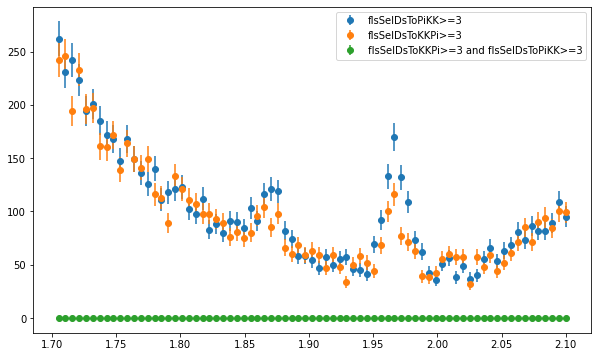

In [32]:
show_inv_mass_plots(DataDf)

In [33]:
del DataDf

### Without using Chi2PCA

In [34]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoChi2PCA.pickle')

In [35]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_NoChi2PCA.parquet')

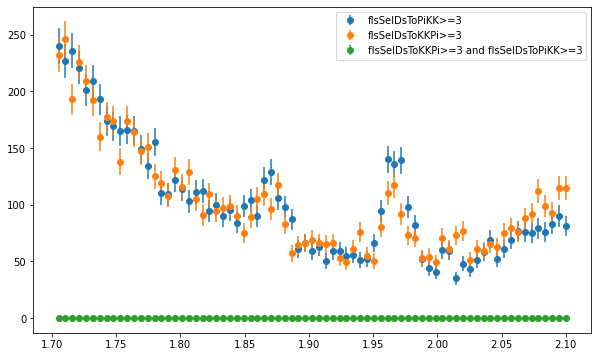

In [36]:
show_inv_mass_plots(DataDf)

In [37]:
del DataDf

### Without using AbsCos3PiK

In [38]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoAbsCos3PiK.pickle')

In [40]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_NoAbsCos3PiK.parquet')

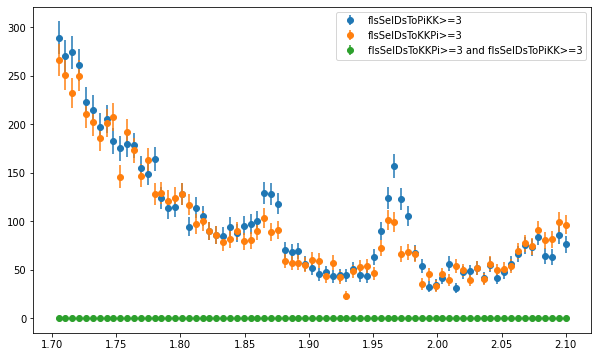

In [41]:
show_inv_mass_plots(DataDf)

In [42]:
del DataDf

### Without using Cpa and CpaXY

In [43]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/NoCPAs.pickle')

In [44]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_NoCPAs.parquet')

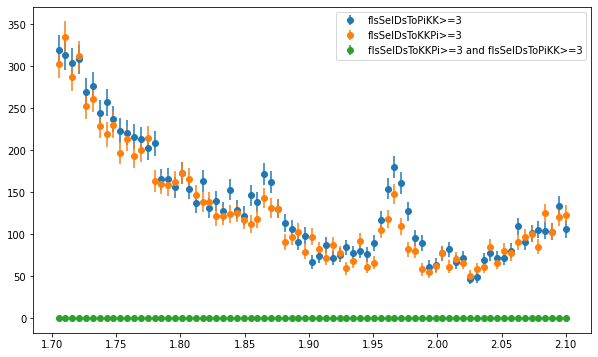

In [45]:
show_inv_mass_plots(DataDf)

In [46]:
del DataDf

### Decay length > 0.05

In [47]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/fDecayLength_0_05.pickle')

In [48]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5 and fDecayLength > 0.05")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_fDecayLength_0_05.parquet')

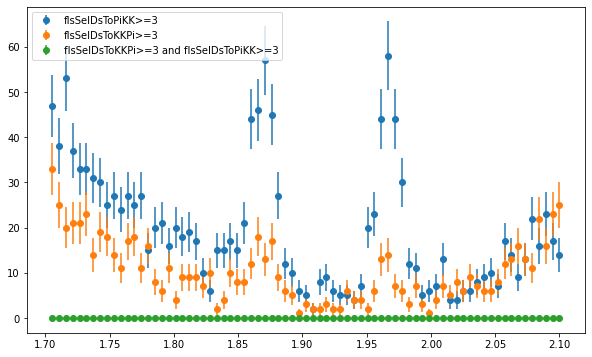

In [60]:
DataDf = pd.read_parquet("/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_fDecayLength_0_05.parquet")
show_inv_mass_plots(DataDf)

In [50]:
del DataDf

### Chi2PCA < 5

In [51]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/fChi2PCA_5.pickle')

In [52]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5 and fChi2PCA < 5")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_fChi2PCA_5.parquet')

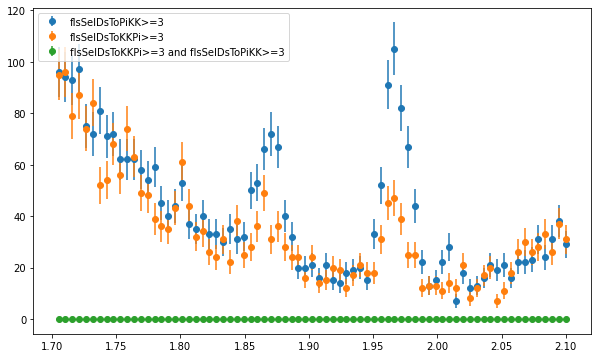

In [53]:
show_inv_mass_plots(DataDf)

In [54]:
del DataDf

### N sigma < 4

In [142]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/PID_4.pickle')

In [141]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5 and \
    ((fIsSelDsToKKPi >=3 and fNSigTpcTofKa0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofPi2 < 4) or (fIsSelDsToPiKK >= 3 and fNSigTpcTofPi0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofKa2 < 4))")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_PID_4.parquet')

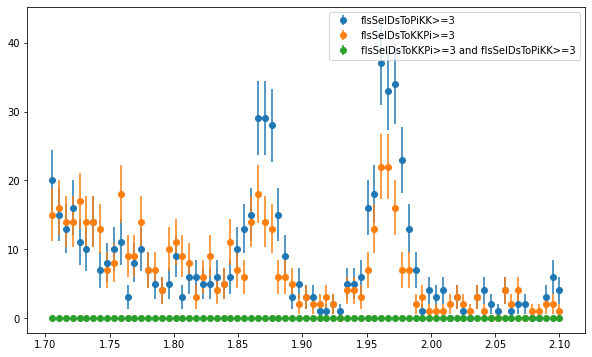

In [143]:
DataDf = pd.read_parquet("/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_PID_4.parquet")
show_inv_mass_plots(DataDf)

In [144]:
del DataDf

In [7]:
DataDfAll = pd.read_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_All.parquet')
DataDfDL = pd.read_parquet("/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_fDecayLength_0_05.parquet")

### Right sideband

In [8]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/Right_Sideband.pickle')

In [12]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5 and \
    ((fIsSelDsToKKPi >=3 and fNSigTpcTofKa0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofPi2 < 4) or (fIsSelDsToPiKK >= 3 and fNSigTpcTofPi0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofKa2 < 4))")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_Right_Sideband.parquet')

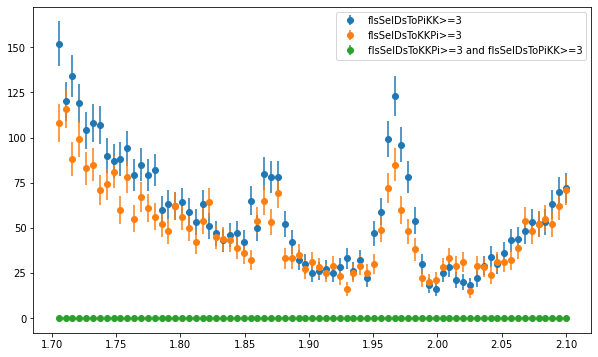

In [13]:
show_inv_mass_plots(DataDf)

### Left sideband

In [17]:
ModelHandl = ModelHandler()
ModelHandl.load_model_handler('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/Left_Sideband.pickle')

In [18]:
ColsToKeep = ["fM", "fPt", "fIsSelDsToPiKK", "fIsSelDsToKKPi"]
DataDf = apply_model_in_batches(ModelHandl, ColsToKeep, '/home/fchinu/Run3/Ds_pp_13TeV/Datasets/Ds_pp_run3_ml/Train175550/LHC22o_pass6_small.parquet', "2<fPt<2.5 and \
    ((fIsSelDsToKKPi >=3 and fNSigTpcTofKa0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofPi2 < 4) or (fIsSelDsToPiKK >= 3 and fNSigTpcTofPi0 < 4 and fNSigTpcTofKa1 < 4 and fNSigTpcTofKa2 < 4))")
DataDf.to_parquet('/home/fchinu/Run3/Ds_pp_13TeV/ML/Models/AppliedData/Df_applied_Left_Sideband.parquet')

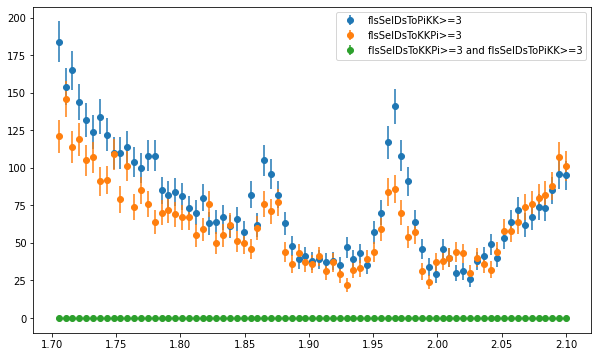

: 

In [19]:
show_inv_mass_plots(DataDf)

## Study residuals

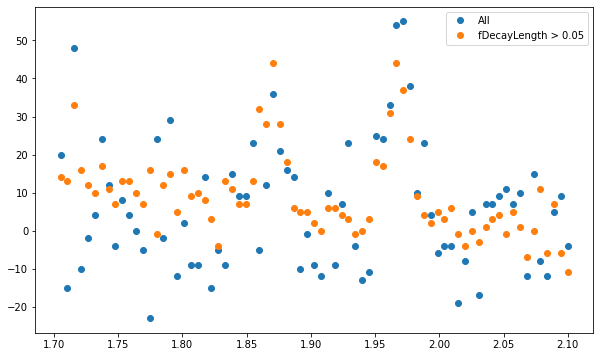

In [14]:
#Draw difference between KKPi and PiKK hypotesis for the datasets
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
dfSelAll = DataDfAll.query(f"ML_output_bkg < 0.01 and ML_output_prompt > 0.5 and fIsSelDsToPiKK>=3")
countsAllPiKK,bin_edges = np.histogram(dfSelAll['fM'],bins=75, range=(1.7, 2.1))

dfSelAll = DataDfAll.query(f"ML_output_bkg < 0.01 and ML_output_prompt > 0.5 and fIsSelDsToKKPi>=3")
countsAllKKPi,bin_edges = np.histogram(dfSelAll['fM'],bins=75, range=(1.7, 2.1))

countsAll = countsAllPiKK - countsAllKKPi
errors = np.sqrt(np.square(countsAllKKPi) + np.square(countsAllPiKK))
plt.errorbar(x=bin_edges[1:], y=countsAll,fmt='o', label='All')

dfSelDL = DataDfDL.query(f"ML_output_bkg < 0.01 and ML_output_prompt > 0.5 and fIsSelDsToPiKK>=3")
countsDLPiKK,bin_edges = np.histogram(dfSelDL['fM'],bins=75, range=(1.7, 2.1))

dfSelDL = DataDfDL.query(f"ML_output_bkg < 0.01 and ML_output_prompt > 0.5 and fIsSelDsToKKPi>=3")
countsDLKKPi,bin_edges = np.histogram(dfSelDL['fM'],bins=75, range=(1.7, 2.1))

countsDL = countsDLPiKK - countsDLKKPi
errors = np.sqrt(np.square(countsDLKKPi) + np.square(countsDLPiKK))
plt.errorbar(x=bin_edges[1:], y=countsDL,  fmt='o', label='fDecayLength > 0.05')

plt.legend()

